needed imports

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import DictionaryLearning
import pickle
import os.path
from os import path
import numpy as np
from keras.utils import plot_model
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Flatten, Reshape, Dropout,AveragePooling2D, MaxPooling2D, BatchNormalization, Lambda, ReLU, Activation, LeakyReLU, Conv2DTranspose, Multiply
from tensorflow.linalg import matmul, matrix_transpose
from keras.losses import kullback_leibler_divergence, binary_crossentropy
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from tensorflow import cast
from keras.optimizers import Adam
from keras.datasets.cifar10 import load_data
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint

optimizer = Adam(0.0002,0.5)
img_rows,img_cols,channels = 32,32,3

create model

In [15]:
# would cause small entries in absulute values to be set to zero and will create sparse vectors
def threshlding(x):
  k=20  #sparsity level 0.1
  top_values, _ = tf.nn.top_k(x, k) # sort values of entry in sparse vector for every pixel - The k largest elements along each last dimensional slice.
  threshold=tf.compat.v1.reduce_min(top_values, reduction_indices=[3], keepdims=True) # get lowest value in sparse vector for every pixel
  mask = (tf.sign(tf.sign(x-threshold)+0.1)+1)/2 
  output = Multiply()([x, mask])
  return output

get_custom_objects().update({'threshlding': Activation(threshlding)})

def define_pursuit(in_shape=(32,32,3)):
  i=Input(in_shape)
  # normal
  x = Conv2D(64, (3,3), padding='same', input_shape=in_shape)(i)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(128, (3,3), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(256, (3,3), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(512, (3,3), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)   # (32,32,512)

  x = Conv2DTranspose(200, (3,3), strides=(1,1), padding='same')(x) # (32,32,200)
  sparse = Activation(threshlding, name='thresholding')(x) # the last dim is the sparse vector. now it is after thresholding and should be sparse
  img = Conv2DTranspose(3, (5,5), strides=(1, 1), padding='same', activation='tanh')(sparse)

  return Model(i, img)

generate complete model

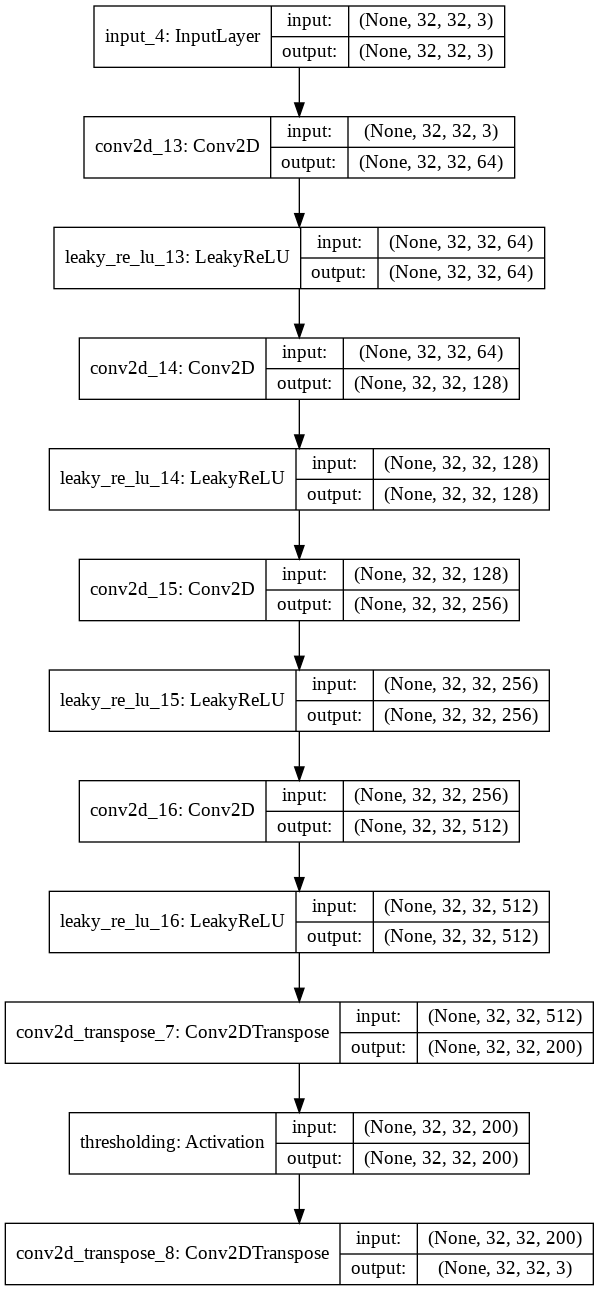

In [16]:
pursuiter = define_pursuit()
pursuiter.compile(optimizer, loss='mse')
plot_model(pursuiter, to_file='pursuiter.png',show_shapes=True,expand_nested=True)

Load the dataset

In [17]:
# load cifar10 data
(X_train, y_train), (X_test, y_test) = load_data()

# convert train and test data to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# scale train and test data to [-1, 1]
X_train = (X_train / 255) * 2 - 1
X_test = (X_test / 255) * 2 - 1

Train

In [18]:
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',baseline=None, restore_best_weights=True)
# zeros = np.zeros((X_train.shape[0],32,32,200))
pursuiter.fit(x=X_train,y=X_train,batch_size=32,epochs=10,validation_split=0.1,callbacks=[earlyStop])
pursuiter.save('trained_pursuiter.h5')

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 99s 2ms/step - loss: 0.0046 - val_loss: 0.0010
Epoch 2/10
45000/45000 [==============================] - 98s 2ms/step - loss: 0.0012 - val_loss: 4.2576e-04
Epoch 3/10
45000/45000 [==============================] - 98s 2ms/step - loss: 6.1792e-04 - val_loss: 3.4387e-04
Epoch 4/10
45000/45000 [==============================] - 98s 2ms/step - loss: 4.4159e-04 - val_loss: 3.6090e-04
Epoch 5/10
45000/45000 [==============================] - 98s 2ms/step - loss: 4.0304e-04 - val_loss: 1.9005e-04
Epoch 6/10
45000/45000 [==============================] - 98s 2ms/step - loss: 3.3774e-04 - val_loss: 2.0415e-04
Epoch 7/10
45000/45000 [==============================] - 98s 2ms/step - loss: 4.0500e-04 - val_loss: 1.7786e-04
Epoch 8/10
45000/45000 [==============================] - 98s 2ms/step - loss: 2.2663e-04 - val_loss: 1.1685e-04
Epoch 9/10
45000/45000 [==============================] - 9

rec==img -> False


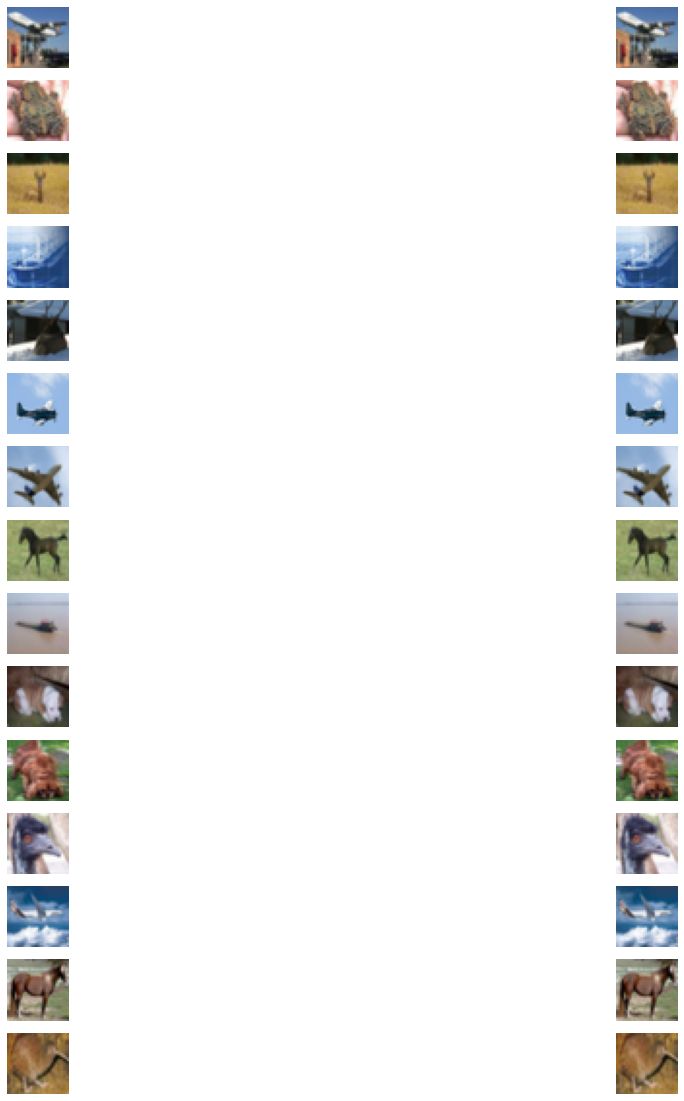

In [40]:
num_images = 15
idx = np.random.permutation(X_test.shape[0])[0:num_images]
imgs = X_test[idx]
imgs.shape
imgs_rec = pursuiter.predict(imgs)

real_idx = np.arange(1,num_images*2,2)
fake_idx = np.arange(2,num_images*2 + 1,2)
plt.figure(figsize=(20,20))
for i in range(num_images):
  plt.subplot(num_images,2,real_idx[i])
  plt.axis('off')
  plt.imshow((imgs[i]+1) / 2)
  plt.subplot(num_images,2,fake_idx[i])
  plt.axis('off')
  plt.imshow((imgs_rec[i]+1)/2)

print(f'rec==img -> {np.array_equal(imgs,imgs_rec)}')


In [20]:
num_images = 5
idx = np.random.permutation(X_test.shape[0])[0:num_images]
y_pred = []
img = []
supports = []
for i,idx in enumerate(idx):
  img.append(X_test[idx][:,:,0])
  y_t = np.array(pursuiter.predict(X_test[idx:idx+1])[0])
  y_pred.append(y_t.reshape(28,28))
  sup = np.array(pursuiter.predict(X_test[idx:idx+1])[1])
  sup = sup.reshape(-1)
  supports.append(np.count_nonzero(sup))

real_idx = np.arange(1,num_images*2,2)
fake_idx = np.arange(2,num_images*2 + 1,2)
for i in range(num_images):
  plt.subplot(num_images,2,real_idx[i])
  plt.axis('off')
  plt.imshow(img[i],cmap="gray")
  plt.subplot(num_images,2,fake_idx[i])
  plt.axis('off')
  plt.imshow(y_pred[i],cmap="gray")

print("average support = ", np.sum(supports)/len(supports))

ValueError: ignored